## 残差块

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module): #@save
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [4]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [5]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## ResNet模型

In [6]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [7]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i ==0 and not first_block:
            blk.append(Residual(input_channels, num_channels,use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [8]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [9]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [10]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 55, 55])
Sequential output shape:	 torch.Size([1, 64, 55, 55])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


training on cpu


KeyboardInterrupt: 

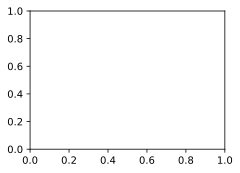

In [11]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

- 学习嵌套函数（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）。
- 残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。
- 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。
- 残差网络（ResNet）对随后的深层神经网络设计产生了深远影响。

## 练习

1. [图7.4.1](http://zh.d2l.ai/chapter_convolutional-modern/googlenet.html#fig-inception)中的Inception块与残差块之间的主要区别是什么？在删除了Inception块中的一些路径之后，它们是如何相互关联的？
2. 参考ResNet论文 ([He et al., 2016](http://zh.d2l.ai/chapter_references/zreferences.html#id60)中的表1，以实现不同的变体。
3. 对于更深层次的网络，ResNet引入了“bottleneck”架构来降低模型复杂性。请试着去实现它。
4. 在ResNet的后续版本中，作者将“卷积层、批量规范化层和激活层”架构更改为“批量规范化层、激活层和卷积层”架构。请尝试做这个改进。详见 ([He et al., 2016](http://zh.d2l.ai/chapter_references/zreferences.html#id61)中的图1。
5. 为什么即使函数类是嵌套的，我们仍然要限制增加函数的复杂性呢？